In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch as torch 
import torch.nn as nn
import torch.optim as optim
import dataset_utils
import torch.nn.functional as F
import torchvision.models as models
from pytorch_metric_learning import distances, losses, miners, reducers

In [2]:
def binarize_hard(x):
    return torch.where(x > 0, 1.0, -1.0)

In [3]:
def binarize_soft(x):
    return torch.tanh(x)
device = "cuda"

In [4]:
# Reference code
class BinaryModel(nn.Module):
    def __init__(self, dim, D, num_classes, enc_type='RP', binary=True, device='cuda', kargs=None):
        super(BinaryModel, self).__init__()
        self.enc_type, self.binary = enc_type, binary	
        self.device = device
        if enc_type in ['RP', 'RP-COS']:
            self.rp_layer = nn.Linear(dim, D).to(device)
            self.class_hvs = torch.zeros(num_classes, D).float().to(device)
            self.class_hvs_nb = torch.zeros(num_classes, D).float().to(device)
        else:
            pass
    #hard sigmoid    
    def weight_binarize(self, W):
       W = torch.where(W<-1,-1,W)
       W = torch.where(W>1,1,W)
       mask1 = (W >= -1) & (W < 0)
       W[mask1] = 2 * W[mask1] + W[mask1]*W[mask1]
       mask2 = (W >= 0) & (W < 1)
       W[mask2] = 2 * W[mask2] - W[mask2]*W[mask2]
       # W[W > 1] = 1
       return W
    #using Bi-Real Approximation     
    def activation_binarize(self,a):
       a = torch.where(a<-1,-1,a)
       a = torch.where(a>1,1,a)
       mask1 = (a >= -1) & (a < 0)
       a[mask1] = 2 * a[mask1] + a[mask1]*a[mask1]
       #a[mask1] = 0
       mask2 = (a >= 0) & (a < 1)
       a[mask2] = 2 * a[mask2] - a[mask2]*a[mask2]
       #a = torch.where((a >= -1) & (a < 0),2*a + torch.pow(a,2) )
       #a = torch.where((a >= 0) & (a < 1), 2*a- torch.pow(a,2))
    #    a [a < -1] = -1
    #    a [a > 1]   =  1
    #    a [(a >= -1) & (a < 0)] = 2*a[(a >= -1) & (a < 0)] + torch.pow(a [(a >= -1) & (a < 0)],2)
    #    a [(a >= 0) & (a < 1)] = 2*a[(a >= 0) & (a < 1)] - torch.pow(a [(a >= 0) & (a < 1)],2)
       return a

    def encoding(self, x):
        if self.enc_type == 'RP':
            #x = self.activation_binarize(x) 
            #need not binarize the inputs 
            #progressively binarize the inputs, after training the weights
            #add some print statements and check 
            #print("The value of weights, before binarization")
            #print(self.rp_layer.weight.data)
            #weights = self.rp_layer.weight.data.clone()
            #weights_bin = self.weight_binarize(weights)
            #self.rp_layer.weight.data = weights_bin.clone() 
            out = self.rp_layer(x)
            #print("The value of weights, after binarization")
            #print(self.rp_layer.weight.data)
        else:
                pass
        
        return binarize_soft(out) if self.binary else out
    
    #Forward Function
    def forward(self, x, embedding=False):
        out = self.encoding(x)
        if embedding:
            out = out
        else:
            out = self.similarity(class_hvs=binarize_hard(self.class_hvs), enc_hv=out)   
        return out
    
    def init_class(self, x_train, labels_train):
        out = self.encoding(x_train)
        if self.binary:
            out = binarize_hard(out)

        for i in range(x_train.size()[0]):
            self.class_hvs[labels_train[i]] += out[i]
        
        if self.binary:
            self.class_hvs = binarize_hard(self.class_hvs)
        
    def HD_train_step(self, x_train, y_train, lr=1.0):
        shuffle_idx = torch.randperm(x_train.size()[0])
        x_train = x_train[shuffle_idx]
        train_labels = y_train[shuffle_idx]
        l= list(self.rp_layer.parameters())
        enc_hvs = binarize_hard(self.encoding(x_train))
        for i in range(enc_hvs.size()[0]):
            sims = self.similarity(self.class_hvs, enc_hvs[i].unsqueeze(dim=0))
            predict = torch.argmax(sims, dim=1)
            
            if predict != train_labels[i]:
                self.class_hvs_nb[predict] -= lr * enc_hvs[i]
                self.class_hvs_nb[train_labels[i]] += lr * enc_hvs[i]
            
            self.class_hvs.data = binarize_hard(self.class_hvs_nb)
    
    def similarity(self, class_hvs, enc_hv):
	    return torch.matmul(enc_hv, class_hvs.t())/class_hvs.size()[1]
    
    

In [5]:
nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset('mnist', 64, "cuda")


In [6]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
num_samples = 500
train_loader_truncated = Subset(train_loader.dataset, range(num_samples))
train_loader_truncated = DataLoader(train_loader_truncated, batch_size=32, shuffle=True)
test_loader_truncated = Subset(test_loader.dataset, range(num_samples))
test_loader_truncated = DataLoader(test_loader_truncated, batch_size=32, shuffle=True)

In [7]:
D = 2000


In [ ]:
print(torch.__version__)

In [14]:
model = BinaryModel(dim = nFeatures, D=D, num_classes=nClasses, enc_type='RP', device="cuda")

In [15]:

model.init_class(x_train = x_train, labels_train=y_train)


In [17]:
lr = 0.0001


In [10]:

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=-1,high=1)
#distance = distances.LpDistance(normalize_embeddings=True, p=2, power=1)
#reducer = reducers.MeanReducer()

In [8]:

def HD_test(model, x_test, y_test):
    #out = model(x_test, embedding=False)
	out = model(x_test)
	preds = torch.argmax(out, dim=-1)
	acc = torch.mean((preds==y_test).float())	
	return acc

def get_Hamming_margin(model, x_test, y_test=None):
	def Hamming_distance(a, b):
		D = a.size()[1]
		return (D - a @ b.T)/2

	# Compute mean Hamming distance between class HVS
	class_hvs = binarize_hard(model.class_hvs.data)
	class_Hamming_distance = Hamming_distance(class_hvs, class_hvs)
	mean_class_Hamming_distance = torch.mean(class_Hamming_distance).item()
	

	# Compute test samples' Hamming distance
	test_enc_hvs = binarize_hard(model(x_test, True)) 
	test_Hamming_dist = Hamming_distance(test_enc_hvs, class_hvs)

	sorted_test_Hamming_distance, _ = torch.sort(test_Hamming_dist, dim=-1, descending=False)
	test_enc_hvs_Hamming_margin = (sorted_test_Hamming_distance[:,1:]-sorted_test_Hamming_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
	mean_test_Hamming_margin = torch.mean(test_enc_hvs_Hamming_margin).item()

	res_dict = {
		"avg_class_Hamming_dist": mean_class_Hamming_distance,
		"avg_test_Hamming_margin": mean_test_Hamming_margin
	}
	return mean_test_Hamming_margin

In [ ]:
num_metric_epochs = 4
device = "cuda"
accuracies = []
accuracies.append(HD_test(model, x_test, y_test).item())
margins = []
margins.append(get_Hamming_margin(model, x_test, y_test))

In [11]:

loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)


In [18]:

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0) 


In [19]:

model.class_hvs = nn.parameter.Parameter(data=model.class_hvs)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard", )

In [20]:
def metric_train(model, mining_func, device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data.reshape(data.size()[0],-1))
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings,labels,indices_tuple)
        loss.backward()
        optimizer.step()
    

In [ ]:
### pytorch-metric-learning using Triplet margin loss ###
for epoch_i in range(1, num_metric_epochs + 1):
    metric_train(model, mining_func, device, train_loader, optimizer)
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins.append(get_Hamming_margin(model, x_test, y_test))


In [ ]:
num_HD_epoch = 20
HD_lr = 1
class_accuracies = []
class_margins = []
for epoch_i in range(1, num_HD_epoch+1):
    model.HD_train_step(x_train, y_train, lr=HD_lr)
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins.append(get_Hamming_margin(model, x_test, y_test))

In [ ]:
plt.plot(accuracies, label="Accuracy", c = "blue")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.title(f"Accuracy of 2 Levels, "+ str(D) + " Dimensions Dataset:mnist")
plt.legend()
plt.show()
print("Maximum Accuracy:{}".format(max(accuracies)))


In [21]:

path = "model"
filename = f'./model/binary_model_{D}.pth'


In [ ]:

torch.save(model, filename)


In [22]:
#model load
#model = BinaryModel(dim = nFeatures, D=D, num_classes=nClasses, enc_type='RP', device="cpu")
model = torch.load(filename)

In [23]:
from gkpd import gkpd
from gkpd.tensorops import kron
from gkpd.tensorops import multidimensional_slice
device = "cuda"

In [24]:
from collections import namedtuple
import torch
import torch.nn as nn

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def calcScaleZeroPoint(min_val, max_val,num_bits=8):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def calcScaleZeroPointSym(min_val, max_val,num_bits=8):
  
  # Calc Scale 
  max_val = max(abs(min_val), abs(max_val))
  qmin = 0.
  qmax = 2.**(num_bits-1) - 1.

  scale = max_val / qmax

  return scale, 0

def quantize_tensor(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

def quantize_tensor_sym(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    max_val = max(abs(min_val), abs(max_val))
    qmin = 0.
    qmax = 2.**(num_bits-1) - 1.

    scale = max_val / qmax   

    q_x = x/scale

    q_x.clamp_(-qmax, qmax).round_()
    q_x = q_x.round()
    return QTensor(tensor=q_x, scale=scale, zero_point=0)

def dequantize_tensor_sym(q_x):
    return q_x.scale * (q_x.tensor.float())

In [25]:
import torch
class FakeQuantOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, num_bits=8, min_val=None, max_val=None):
        x = quantize_tensor(x,num_bits=num_bits, min_val=min_val, max_val=max_val)
        x = dequantize_tensor(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # straight through estimator
        return grad_output, None, None, None

In [34]:
class KroneckerDecomposition_new(nn.Module):
    def __init__(self, A, B, dim, D, num_classes, binary=True, num_bits=4):
        super(KroneckerDecomposition_new, self).__init__()
        self.A = torch.nn.Parameter(torch.tensor(A).clone().detach().requires_grad_(True))
        self.binary = binary
        self.B = torch.nn.Parameter(torch.tensor(B).clone().detach().requires_grad_(True))
        self.class_hvs = torch.zeros(num_classes, D).float().to(device)
        self.class_hvs_nb = torch.zeros(num_classes, D).float().to(device)
        self.num_bits = num_bits

    def weight_binarize(self, W):
       W = torch.where(W<-1,-1,W)
       W = torch.where(W>1,1,W)
       mask1 = (W >= -1) & (W < 0)
       W[mask1] = 2 * W[mask1] + W[mask1]*W[mask1]
       mask2 = (W >= 0) & (W < 1)
       W[mask2] = 2 * W[mask2] - W[mask2]*W[mask2]
       W = W.float()
       return W
        
    def forward(self,x, embedding=False):
        out = self.encoding(x)
        if embedding:
            out = out
        else:
            out = self.similarity(class_hvs=binarize_hard(self.class_hvs), enc_hv=out)   
        return out
    
    def encoding(self,x):
        #print("Entering Encoding")
        #Comment
        #Can try to run without binarizing also 
        #Comment
        # the next two lines can be commented
        #bin_A = self.weight_binarize(self.A)
        #bin_B = self.weight_binarize(self.B)
        #print("Finished binarizing")
        #Comment
        #print("before quant, A",self.A.data)
        self.A.data = FakeQuantOp.apply(self.A.data, self.num_bits)
        #print("A",self.A.data)
        self.B.data = FakeQuantOp.apply(self.B.data, self.num_bits)
        #print("B",self.B.data)
        weight_kron = kron(self.A, self.B)
        #print("weight kron",weight_kron)
        #print(weight_kron.grad_fn)
        #weight_kron = nnq.DeQuantize()(weight_kron)
        #print(weight_kron.grad_fn)
        #weight_kron = gkpd(weight_kron,tensor.ones(rank,))
        weight_kron_size = list(weight_kron.size())
        weight_kron = weight_kron.view(weight_kron_size[0],weight_kron_size[1])
        # #weight_kron= Variable(weight_kron.data, requires_grad=True)
        # #print("Finished reshape")
        x = FakeQuantOp.apply(x, self.num_bits)
        weight_kron = FakeQuantOp.apply(weight_kron, self.num_bits)
        x=x.to(device)
        weight_kron = weight_kron.to(device)
        out = torch.matmul(x,weight_kron.t())
        #print("Encoding Done")
        return binarize_soft(out)
    



    def init_class(self, x_train, labels_train):
        out = self.encoding(x_train)
        if self.binary:
            out = binarize_hard(out)

        for i in range(x_train.size()[0]):
            self.class_hvs[labels_train[i]] += out[i]
        
        if self.binary:
            self.class_hvs = binarize_hard(self.class_hvs)
    
    def HD_train_step(self, x_train, y_train, lr=1.0):
        shuffle_idx = torch.randperm(x_train.size()[0])
        x_train = x_train[shuffle_idx]
        train_labels = y_train[shuffle_idx]
        #l= list(self.rp_layer.parameters())
        enc_hvs = binarize_hard(self.encoding(x_train))
        for i in range(enc_hvs.size()[0]):
            sims = self.similarity(self.class_hvs, enc_hvs[i].unsqueeze(dim=0))
            predict = torch.argmax(sims, dim=1)
            
            if predict != train_labels[i]:
                self.class_hvs_nb[predict] -= lr * enc_hvs[i]
                self.class_hvs_nb[train_labels[i]] += lr * enc_hvs[i]
            
            self.class_hvs.data = binarize_hard(self.class_hvs_nb)
    
    def similarity(self, class_hvs, enc_hv):
	    return torch.matmul(enc_hv, class_hvs.t())/class_hvs.size()[1]
    
    


In [32]:
def  metric_train_svd (model, loss_func, mining_func, device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data.reshape(data.size()[0],-1))
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings,labels,indices_tuple)
        loss.backward()
        print(loss.grad_fn)
        optimizer.step()


In [28]:
w = model.rp_layer.weight.data
w = w.view(D,nFeatures,1,1)
print(w.shape)
rank = 16
a_shape, b_shape = (rank, 40, 28, 1, 1), (rank, 50, 28, 1, 1)
a_hat, b_hat = gkpd(w, a_shape[1:], b_shape[1:])

torch.Size([2000, 784, 1, 1])


In [35]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
device = "cuda"
kronecker_model = KroneckerDecomposition_new(A=a_hat,B=b_hat,dim = nFeatures, D=D, num_classes=nClasses, num_bits=4)


/tmp/ipykernel_99099/1287982236.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.A = torch.nn.Parameter(torch.tensor(A).clone().detach().requires_grad_(True))
/tmp/ipykernel_99099/1287982236.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.B = torch.nn.Parameter(torch.tensor(B).clone().detach().requires_grad_(True))


In [ ]:
x = torch.tensor([1,2,3,4]).float()
out = kronecker_model.encoding(x)

In [36]:
kronecker_model.init_class(x_train=x_train, labels_train = y_train)

In [37]:

lr = 0.0001
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
optimizer = optim.Adam(kronecker_model.parameters(), lr=lr, weight_decay=0) 
kronecker_model.class_hvs = nn.parameter.Parameter(data=kronecker_model.class_hvs)
kronecker_accuracies = []
kronecker_margins = []
kronecker_accuracies.append(HD_test(kronecker_model, x_test, y_test).item())
print("first accuracy",kronecker_accuracies[0])
#find the initial accuracy right after this
kronecker_margins.append(get_Hamming_margin(kronecker_model, x_test, y_test))
num_samples = 1000
train_loader_truncated = Subset(train_loader.dataset, range(num_samples))
train_loader_truncated = DataLoader(train_loader_truncated, batch_size=256, shuffle=True)

first accuracy 0.8282999992370605


In [39]:
num_metric_epochs = 4
print("Triplet Loss")
for epoch_i in range(1, num_metric_epochs + 1):
    metric_train_svd(kronecker_model, loss_func, mining_func, device, train_loader_truncated, optimizer)
    #print("metric_Train_done")
    kronecker_accuracies.append(HD_test(kronecker_model, x_test, y_test).item())
    #print("accuracies done")
    kronecker_margins.append(get_Hamming_margin(kronecker_model, x_test, y_test))
    #print("margins done")
    print("Epoch",epoch_i)
    #Comment
    #Take a note of the first accuracy
    print("Accuracies",HD_test(kronecker_model, x_test, y_test).item())

Triplet Loss
Epoch 1
Accuracies 0.8274999856948853
Epoch 2
Accuracies 0.8269999623298645
Epoch 3
Accuracies 0.8273999691009521
Epoch 4
Accuracies 0.8277999758720398


In [40]:
num_HD_epoch = 20
HD_lr = 1
kronecker_class_accuracies = []
kronecker_class_margins = []
for epoch_i in range(1, num_HD_epoch+1):
    kronecker_model.HD_train_step(x_train, y_train, lr=HD_lr)
    #Comment
    #Wrong accuracies
    #retrain again 
    kronecker_accuracies.append(HD_test(kronecker_model, x_test, y_test).item())
    kronecker_margins.append(get_Hamming_margin(kronecker_model, x_test, y_test))

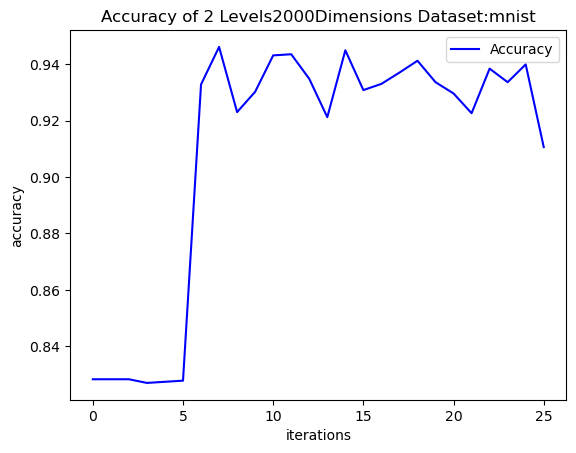

Maximum Accuracy:0.9460999965667725


In [41]:
plt.plot(kronecker_accuracies, label="Accuracy", c = "blue")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.title("Accuracy of 2 Levels"+ str(D)+"Dimensions Dataset:mnist")
plt.legend()
plt.show()
print("Maximum Accuracy:{}".format(max(kronecker_accuracies)))

In [ ]:
import pandas as pd

# read in the existing CSV file, or create a new DataFrame if the file doesn't exist
try:
    df = pd.read_csv('results.csv')
except FileNotFoundError:
    df = pd.DataFrame()
    